In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
base_fp = '/trace/group/rounce/cvwilson/Output/'
home_fp = '/trace/home/cvwilson/research/'
colors = ['#63c4c7','#fcc02e','#4D559C','#60C252','#BF1F6A',
              '#F77808','#298282','#999999','#FF89B0','#427801']

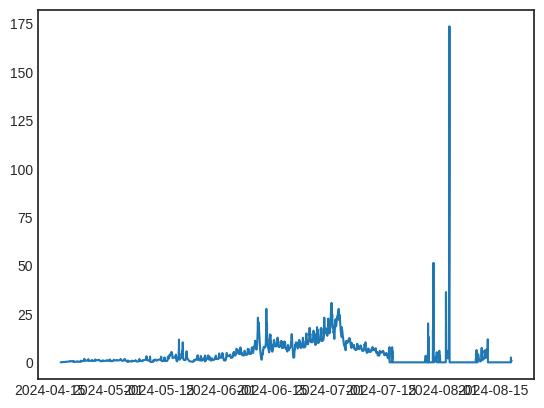

In [4]:
from pebsi.processing.plotting_fxns import * 
ds = xr.open_dataset('/trace/group/rounce/cvwilson/Output/08_02_B_0/grid_08_02_set67_run0_0.nc')
# dates = pd.date_range(ds.time.values[0], ds.time.values[-1])
# visualize_layers(ds, dates, ['layergrainsize'])

df = pd.read_csv('../climate_data/AWS/Processed/gulkana/gulkana2024_walbedo.csv',parse_dates=True, index_col=0)
albedo_meas = df['albedo'].resample('d').mean()
plt.plot(ds.time.values, ds.layerBC.isel(layer=0).values)
# plt.plot(albedo_meas.index, albedo_meas.values)
plt.show()

In [ ]:
def compute_ddf(ds, time_res = '1D'):
    """
    Compute daily Positive Degree Day (PDD) factor from hourly temperature and melt data.

    Parameters:
        df (pd.DataFrame): DataFrame with hourly data.
    Returns:
        pd.DataFrame: Daily PDD factor with columns ['date', 'daily_melt', 'positive_temp_sum', 'pdd_factor']
    """

    # Clip temperature to positive values
    positive_temp = ds['airtemp'].clip(min=0)

    # Resample to daily
    resampled_melt = ds['melt'].resample({'time': time_res}).sum() * 1000
    resampled_positive_temp = positive_temp.resample({'time': time_res}).sum()
    resampled_albedo = ds['albedo'].resample({'time':time_res}).mean()
    resampled_acc = ds['accum'].resample({'time': time_res}).sum() * 1000

    # Compute PDD factor
    pdd_factor = resampled_melt / resampled_positive_temp
    pdd_factor = pdd_factor.where(np.isfinite(pdd_factor))  # mask inf/nan
    pdd_factor = pdd_factor.where(resampled_melt > 10)

    # Return as new dataset
    return xr.Dataset({
        'melt':resampled_melt,
        'pdds':resampled_positive_temp,
        'ddf':pdd_factor,
        'albedo':resampled_albedo,
        'accum':resampled_acc
    })

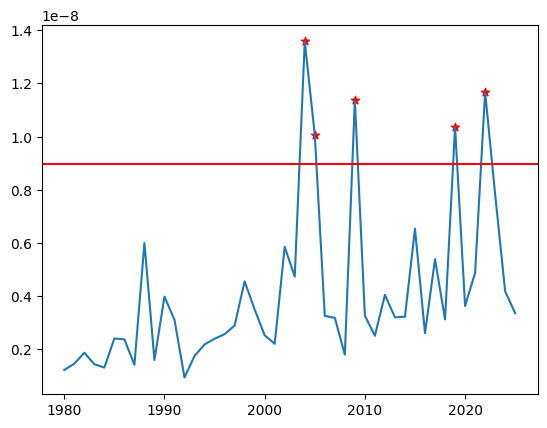

In [4]:
ds = xr.open_dataset('../climate_data/MERRA2/BCDP002/MERRA2_BCDP002_gulkana_alltime.nc')
ds2 = xr.open_dataset('../climate_data/MERRA2/BCWT002/MERRA2_BCWT002_gulkana_alltime.nc')
ds['BCDP002'] = ds['BCDP002'] + ds2['BCWT002']
# define time variables
months = ds['time'].dt.month
days = ds['time'].dt.day
# create time mask from apr 1 to sep 30 (inclusive)
mask = ((months > 3) & (months < 10)) | ((months == 4) & (days >= 1)) | ((months == 10) & (days == 1))
ds_season = ds.where(mask, drop=True)
annual_sums = ds_season.groupby('time.year').sum()
plt.plot(annual_sums.year, annual_sums['BCDP002'].values)
plt.axhline(np.quantile(annual_sums['BCDP002'].values, 0.90), c='r')

threshold = np.quantile(annual_sums['BCDP002'].values, 0.90)
base_idx = np.where(annual_sums['BCDP002'].values <= threshold)[0]
fire_idx = np.where(annual_sums['BCDP002'].values > threshold)[0]
plt.scatter(annual_sums.year.values[fire_idx], annual_sums['BCDP002'].values[fire_idx], color='red', marker='*')
plt.show()

fire_years = annual_sums.year.values[fire_idx]
base_years = annual_sums.year.values[base_idx]

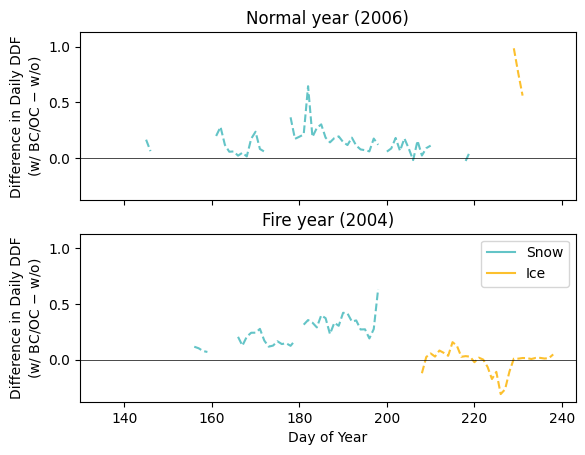

In [15]:
for plot_type in ['difference', ]: # 'values',
    fig, axes = plt.subplots(2, sharex=True, sharey=True)
    for s, site in enumerate(['B']):
        ds_base = xr.open_dataset(base_fp + f'gulkana{site}_2025_11_24_base_long_0.nc')
        ds_noBCOC = xr.open_dataset(base_fp + f'gulkana{site}_2025_11_24_noBCOC_long_0.nc')
        # ds_noBCOC = ds_base
        ds_dict = {'wBCOC':ds_base, 'base':ds_noBCOC}
        linestyles = ['-','--']
        
        for ax, years, label in zip(axes,
                                    [[2006], [2004]],
                                    ['Normal year (2006)', 'Fire year (2004)']):

            x_ice = []
            y_ice = []
            x_snow = []
            y_snow = []
            for ls, dataset in zip(['-','--'], ['base','wBCOC']):
                ds = ds_dict[dataset]
                # collect daily ddf values across selected years
                ddfs_snow = []
                ddfs_ice = []

                for year in years:
                    if year < 2000 or year > 2024:
                        continue
                    
                    # slice to Apr 1 – Oct 1 for that year
                    subset = ds.sel(time=slice(f"{year}-04-01", f"{year}-10-01"))
                    melt = subset['melt'].resample(time='1D').sum() * 1000
                    PDDs = subset['airtemp'].resample(time='1D').mean().clip(min=0)
                    albedo = subset['albedo'].resample(time='1D').mean()

                    condition = (melt > 10) & (albedo > 0.486)
                    daily_ddf = (melt / PDDs).where(condition)
                    ddfs_snow.append(daily_ddf)

                    condition = (albedo <= 0.486)
                    daily_ddf = (melt / PDDs).where(condition)
                    ddfs_ice.append(daily_ddf)

                # concat across years and average by DOY
                all_ddf_snow = xr.concat(ddfs_snow, dim="time")
                median_ddf_snow = all_ddf_snow.groupby("time.dayofyear").median()
                all_ddf_ice = xr.concat(ddfs_ice, dim="time")
                median_ddf_ice = all_ddf_ice.groupby("time.dayofyear").median()

                # plot one line per category
                if plot_type == 'values':
                    ax.plot(median_ddf_snow['dayofyear'], median_ddf_snow,
                            color=colors[0], linestyle=ls)
                    ax.plot(median_ddf_ice['dayofyear'], median_ddf_ice,
                            color=colors[1], linestyle=ls)
                elif plot_type == 'difference':
                    x_snow.append(median_ddf_snow['dayofyear'])
                    x_ice.append(median_ddf_ice['dayofyear'])
                    y_snow.append(median_ddf_snow )
                    y_ice.append(median_ddf_ice)
                if ls == '-':
                    ax.plot(np.nan, np.nan, color=colors[0], label=f'Snow')
                    ax.plot(np.nan, np.nan, color=colors[1], label=f'Ice')
            if plot_type == 'difference':
                ax.plot(x_ice[0], y_ice[1] - y_ice[0],
                            color=colors[1], linestyle=ls)
                ax.plot(x_snow[0], y_snow[1] - y_snow[0],
                        color=colors[0], linestyle=ls)
                ax.axhline(0, color='k', linewidth=0.5)
            ax.set_title(label)

    ax.set_xlabel("Day of Year")
    ylabel = 'Daily DDF' if plot_type != 'difference' else 'Difference in Daily DDF\n(w/ BC/OC $-$ w/o)'
    ax.set_ylabel(ylabel)
    axes[0].set_ylabel(ylabel)
    if plot_type != 'difference':
        ax.plot(np.nan, np.nan, color='gray', linestyle='-', label='With BC/OC')
        ax.plot(np.nan, np.nan, color='gray', linestyle='--', label='No BC/OC')
    ax.legend()
    plt.show()

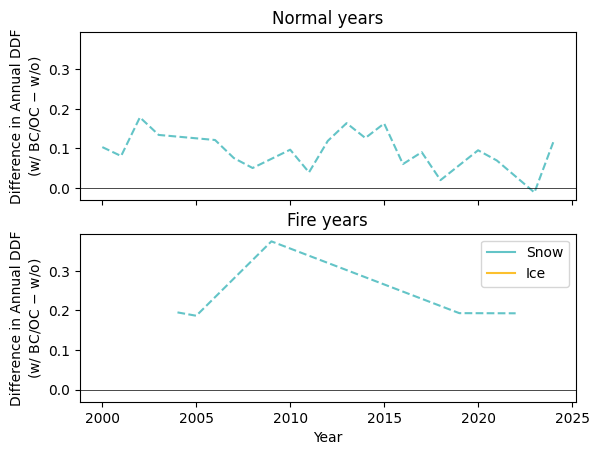

In [16]:
plot_type = 'difference'
fig, axes = plt.subplots(2, sharex=True, sharey=True)
for s, site in enumerate(['B']):
    ds_base = xr.open_dataset(base_fp + f'gulkana{site}_2025_11_24_base_long_0.nc')
    ds_noBCOC = xr.open_dataset(base_fp + f'gulkana{site}_2025_11_24_noBCOC_long_0.nc')
    # ds_noBCOC = ds_base
    ds_dict = {'wBCOC':ds_base, 'base':ds_noBCOC}
    linestyles = ['-','--']
    
    for ax, years, label in zip(axes,
                                [base_years, fire_years],
                                ['Normal years', 'Fire years']):

        x_ice = []
        y_ice = []
        x_snow = []
        y_snow = []
        for ls, dataset in zip(['-','--'], ['base','wBCOC']):
            ds = ds_dict[dataset]
            # collect daily ddf values across selected years
            ddfs_snow = []
            ddfs_ice = []

            for year in years:
                if year < 2000 or year > 2024:
                    ddfs_snow.append(np.nan)
                    ddfs_ice.append(np.nan)
                    continue
                
                # slice to Apr 1 – Oct 1 for that year
                subset = ds.sel(time=slice(f"{year}-04-01", f"{year}-10-01"))
                melt = subset['melt'].resample(time='1D').sum() * 1000
                PDDs = subset['airtemp'].resample(time='1D').mean().clip(min=0)
                albedo = subset['albedo'].resample(time='1D').mean()
                layertype = subset['layertype'].isel(layer=0).resample(time='1D').median()

                condition = layertype < 1
                seasonal_ddf = melt.where(condition).sum() / PDDs.where(condition).sum()
                ddfs_snow.append(seasonal_ddf.values)

                condition = layertype >= 1
                seasonal_ddf = melt.where(condition).sum() / PDDs.where(condition).sum()
                ddfs_ice.append(seasonal_ddf.values)

            # plot one line per category
            if plot_type == 'values':
                ax.plot(years, seasonal_ddf,
                        color=colors[0], linestyle=ls)
                ax.plot(years, seasonal_ddf,
                        color=colors[1], linestyle=ls)
            elif plot_type == 'difference':
                y_snow.append(np.array(ddfs_snow))
                y_ice.append(np.array(ddfs_ice))
            if ls == '-':
                ax.plot(np.nan, np.nan, color=colors[0], label=f'Snow')
                ax.plot(np.nan, np.nan, color=colors[1], label=f'Ice')
        if plot_type == 'difference':
            # ax.plot(years, y_ice[1] - y_ice[0],
            #             color=colors[1], linestyle=ls)
            ax.plot(years, y_snow[1] - y_snow[0],
                    color=colors[0], linestyle=ls)
            ax.axhline(0, color='k', linewidth=0.5)
        ax.set_title(label)

ax.set_xlabel('Year')
ylabel = 'Annual DDF' if plot_type != 'difference' else 'Difference in Annual DDF\n(w/ BC/OC $-$ w/o)'
ax.set_ylabel(ylabel)
axes[0].set_ylabel(ylabel)
if plot_type != 'difference':
    ax.plot(np.nan, np.nan, color='gray', linestyle='-', label='With BC/OC')
    ax.plot(np.nan, np.nan, color='gray', linestyle='--', label='No BC/OC')
ax.legend()
plt.show()

In [3]:
site = 'A'
ds = xr.open_dataset(base_fp + f'/08_01_{site}_0/grid_08_01_set67_run0_0.nc')
# ds = ds.sel(time=pd.date_range('2020-04-01','2024-08-18',freq='h'))

/tmp/ipykernel_4145993/2122832891.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left')


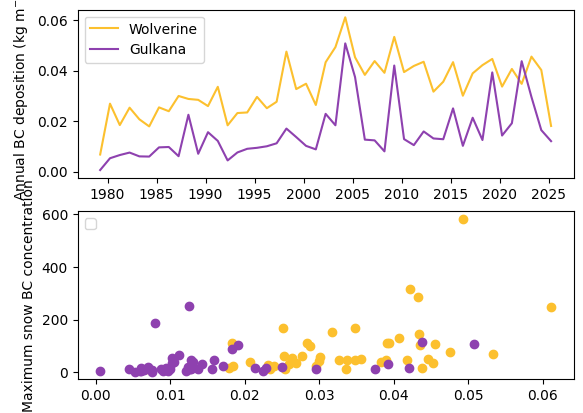

In [41]:
site_colors = {'EC':'#fcc02e',
               'T':    "#E14E9A", 
    'Z':    "#8E41AF", 

    'KQU':"#28CD8E",'KPS':"#0077FF"
}

bcwtw = xr.open_dataarray(home_fp + 'climate_data/MERRA2/BCWT002/MERRA2_BCWT002_wolverine_alltime.nc')
bcdpw = xr.open_dataarray(home_fp + 'climate_data/MERRA2/BCDP002/MERRA2_BCDP002_wolverine_alltime.nc')

bcwtg = xr.open_dataarray(home_fp + 'climate_data/MERRA2/BCWT002/MERRA2_BCWT002_gulkana_alltime.nc')
bcdpg = xr.open_dataarray(home_fp + 'climate_data/MERRA2/BCDP002/MERRA2_BCDP002_gulkana_alltime.nc')

bcw = (bcwtw.values + bcdpw).resample(time='YS-APR').sum() * 3600 * 1000 # in kg/m2
bcg = (bcwtg + bcdpg).resample(time='YS-APR').sum() * 3600 * 1000 # in kg/m2

fig, (ax, ax1) = plt.subplots(2)
ax.plot(bcw.time, bcw.values, color=site_colors['EC'], label='Wolverine')
ax.plot(bcg.time, bcg.values, color=site_colors['Z'], label='Gulkana')
ax.set_ylabel('Annual BC deposition (kg m$^{-2}$)')
ax.legend()

dsg = xr.open_dataset(base_fp + 'Gulkana_2025_09_25_longZ_1.nc')
dsw = xr.open_dataset(base_fp + 'Wolverine_2025_09_25_longEC_1.nc')

bclg = dsg.layerBC.sel(layer=0).resample(time='d').mean()
bclw = dsw.layerBC.sel(layer=0).resample(time='d').mean()
maxbcg = bclg.resample(time='YS-APR').max()
maxbcw = bclw.resample(time='YS-APR').max()

ddfg = compute_ddf(dsg, 'YS')
ddfw = compute_ddf(dsw, 'YS')

ax1.scatter(bcw.values[:-2], maxbcw.values[:-1], color=site_colors['EC'])
ax1.scatter(bcg.values[:-2], maxbcg.values[:-1], color=site_colors['Z'])
ax1.set_ylabel('Maximum snow BC concentration')

# ax1.scatter(bcw.values[:-2], ddfw.ddf.values[:-1], color=site_colors['EC'])
# ax1.scatter(bcg.values[:-2], ddfg.ddf.values[:-1], color=site_colors['Z'])

# ax1.plot(ddfg.time.values[:-1], ddfg.ddf.values[:-1], color=site_colors['Z'], label='Gulkana Z')
# ax1.plot(ddfw.time.values[:-1], ddfw.ddf.values[:-1], color=site_colors['EC'], label='Wolverine EC')
# plt.axvline(pd.to_datetime('2004-01-01'), color='k', label='2004')
# plt.axvline(pd.to_datetime('2019-01-01'),color='k', linestyle='--', label='2019')
# ax1.set_ylabel('Annual degree day factor (mm w.e. / C / day)')
ax1.legend(loc='upper left')
plt.show()

In [5]:
data = {'wolverine': pd.DataFrame({'year':np.arange(1980, 2025)}), 
        'gulkana': pd.DataFrame({'year':np.arange(1980, 2025)})}

for glacier in ['gulkana','wolverine']:
    bcwt = xr.open_dataarray(home_fp + f'climate_data/MERRA2/BCWT002/MERRA2_BCWT002_{glacier}_alltime.nc')
    bcdp = xr.open_dataarray(home_fp + f'climate_data/MERRA2/BCDP002/MERRA2_BCDP002_{glacier}_alltime.nc')
    bc = (bcwt.values + bcdp).resample(time='YS').sum() * 3600 * 1000 # in kg/m2
    data[glacier]['annual_bc_dep'] = bc.values[:-1]
    bcwt.close()
    bcdp.close()

    ocwt = xr.open_dataarray(home_fp + f'climate_data/MERRA2/OCWT002/MERRA2_OCWT002_{glacier}_alltime.nc')
    ocdp = xr.open_dataarray(home_fp + f'climate_data/MERRA2/OCDP002/MERRA2_OCDP002_{glacier}_alltime.nc')
    oc = (ocwt.values + ocdp).resample(time='YS').sum() * 3600 * 1000 # in kg/m2
    data[glacier]['annual_oc_dep'] = oc.values[:-1]
    ocwt.close()
    ocdp.close()

    # Annual degree-day factor
    if glacier == 'gulkana':
        ds = xr.open_dataset(base_fp + 'Gulkana_2025_09_25_longT_1.nc')
    else:
        ds = xr.open_dataset(base_fp + 'Wolverine_2025_09_25_longEC_1.nc')
    annual_ddf = compute_ddf(ds, 'YS')
    data[glacier]['annual_ddf'] = annual_ddf.ddf.values[:-1]
    data[glacier]['annual_melt'] = annual_ddf.melt.values[:-1]
    data[glacier]['annual_accum'] = annual_ddf.accum.values[:-1]
    
    # Annual maximum (daily avg to smooth outliers) BC/OC concentration
    bclayer = ds.layerBC.sel(layer=0).resample(time='d').mean()
    max_annual_bc = bclayer.resample(time='YS').max()
    oclayer = ds.layerOC.sel(layer=0).resample(time='d').mean()
    max_annual_oc = oclayer.resample(time='YS').max()
    data[glacier]['annual_max_bc_snow'] = max_annual_bc.values[:-1]
    data[glacier]['annual_max_oc_snow'] = max_annual_oc.values[:-1]

    # Minimum annual albedo
    min_annual_albedo = ds.albedo.resample(time='YS').min()
    data[glacier]['annual_min_albedo'] = min_annual_albedo.values[:-1]
    ds.close()

In [15]:
dfB = pd.DataFrame({'year':np.arange(2000, 2025)})

bcwt = xr.open_dataarray(home_fp + f'climate_data/MERRA2/BCWT002/MERRA2_BCWT002_{glacier}_alltime.nc').sel(time=pd.date_range('2000-01-01 00:30','2025-01-01',freq='h'))
bcdp = xr.open_dataarray(home_fp + f'climate_data/MERRA2/BCDP002/MERRA2_BCDP002_{glacier}_alltime.nc').sel(time=pd.date_range('2000-01-01 00:30','2025-01-01',freq='h'))
bc = (bcwt.values + bcdp).resample(time='YS').sum() * 3600 * 1000 # in kg/m2
dfB['annual_bc_dep'] = bc.values
bcwt.close()
bcdp.close()

ocwt = xr.open_dataarray(home_fp + f'climate_data/MERRA2/OCWT002/MERRA2_OCWT002_{glacier}_alltime.nc').sel(time=pd.date_range('2000-01-01 00:30','2025-01-01',freq='h'))
ocdp = xr.open_dataarray(home_fp + f'climate_data/MERRA2/OCDP002/MERRA2_OCDP002_{glacier}_alltime.nc').sel(time=pd.date_range('2000-01-01 00:30','2025-01-01',freq='h'))
oc = (ocwt.values + ocdp).resample(time='YS').sum() * 3600 * 1000 # in kg/m2
dfB['annual_oc_dep'] = oc.values
ocwt.close()
ocdp.close()

# Annual degree-day factor
ds = xr.open_dataset(base_fp + '2025_11_20_siteB_1.nc') # f'/08_01_{site}_0/grid_08_01_set67_run0_0.nc')
ds_ddf = ds.where(ds.layergrainsize.isel(layer=0) < 1800)
annual_ddf = compute_ddf(ds_ddf, 'YS')
dfB['annual_ddf_snow'] = annual_ddf.ddf.values
dfB['annual_melt'] = annual_ddf.melt.values
dfB['annual_accum'] = annual_ddf.accum.values
dfB['annual_pdds'] = annual_ddf.positive_temp_sum.values

# Annual maximum (daily avg to smooth outliers) BC/OC concentration
bclayer = ds.layerBC.sel(layer=0).resample(time='d').mean()
max_annual_bc = bclayer.resample(time='YS').max()
oclayer = ds.layerOC.sel(layer=0).resample(time='d').mean()
max_annual_oc = oclayer.resample(time='YS').max()
dfB['annual_max_bc_snow'] = max_annual_bc.values
dfB['annual_max_oc_snow'] = max_annual_oc.values

# Annual days of ice exposure
ice_exposed = (ds.layertype.isel(layer=0) == 2)
ice_daily = ice_exposed.resample(time='1D').max()
ice_days_per_year = ice_daily.groupby('time.year').sum()
dfB['annual_ice_days'] = ice_days_per_year

# Minimum annual snow albedo
snow_albedo = ds.where(ds.layergrainsize.isel(layer=0) < 1800).albedo
min_annual_albedo = ds.albedo.resample(time='YS').min()
dfB['annual_min_albedo'] = min_annual_albedo.values
ds.close()

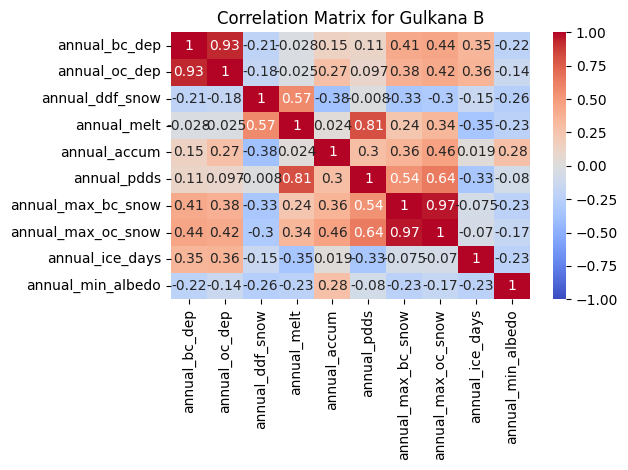

In [16]:
# Calculate correlation matrix
dfB = dfB.set_index('year')
corr = dfB.corr()

# Plot
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Correlation Matrix for Gulkana B')
plt.tight_layout()
plt.show()

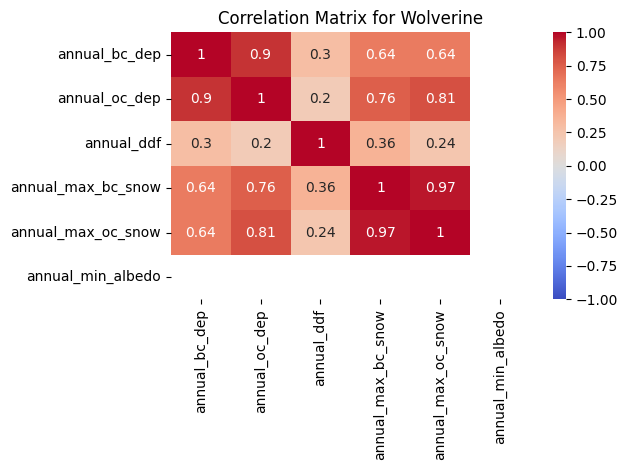

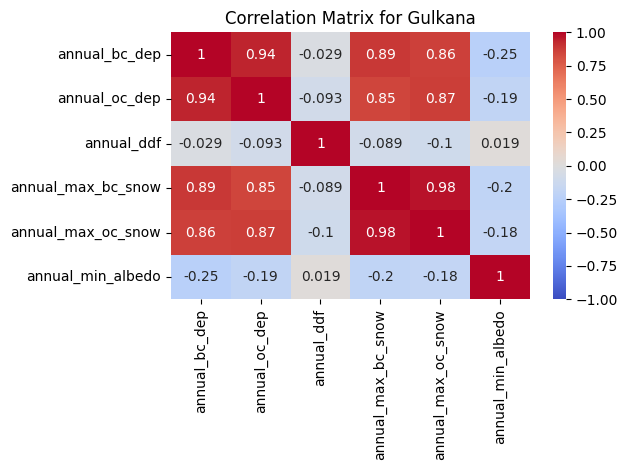

In [58]:
for glacier in ['wolverine','gulkana']:
    df = data[glacier]
    df = df.set_index('year')

    # Calculate correlation matrix
    corr = df.corr()

    # Plot
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {glacier.capitalize()}')
    plt.tight_layout()
    plt.show()